#  Support Vector Machine on DonorsChoose

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible How to increase the consistency of project vetting across different volunteers to improve the experience for teachers How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py

import chart_studio.plotly as py


from collections import Counter

## 1. LOAD AND PROCESS DATA

### 1.1 Reading Data

In [2]:
data=pd.read_csv("train_data.csv")

resource_data=pd.read_csv("resources.csv")
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
price_data=resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [4]:
project_data=pd.merge(data, price_data, on='id', how='left')

In [5]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

### 1.2 process Project Essay

In [6]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22


In [7]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                project_data["project_essay_2"].map(str) + \
                project_data["project_essay_3"].map(str) + \
                project_data["project_essay_4"].map(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['cleaned_essay']=preprocessed_essays

100%|██████████| 109248/109248 [00:58<00:00, 1869.44it/s]


### 1.2 process Project Title

In [11]:
# https://stackoverflow.com/a/47091490/4084039
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
project_data['cleaned_project_title']=preprocessed_title

100%|██████████| 109248/109248 [00:02<00:00, 37498.59it/s]


### 1.3 teacher_prefix

In [12]:
temp1=data.teacher_prefix.apply(lambda x: str(x).replace('.', ''))
project_data['teacher_prefix']=temp1
project_data['teacher_prefix'].value_counts()


Mrs        57269
Ms         38955
Mr         10648
Teacher     2360
Dr            13
nan            3
Name: teacher_prefix, dtype: int64

### 1.4 project grade

In [13]:
project_data.project_grade_category.value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [14]:
grade_list=[]
for i in project_data['project_grade_category'].values:
    i=i.replace(' ','_')
    i=i.replace('-','_')
    grade_list.append(i.strip()) 
    
    
project_data['project_grade_category']=grade_list  
       
   

In [15]:
project_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37137
Grades_6_8       16923
Grades_9_12      10963
Name: project_grade_category, dtype: int64

### 1.5 project_subject_categories

In [16]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.6 project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.7 counting words in title

In [18]:
#https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
project_data['totalwords_title'] = project_data['cleaned_project_title'].str.split().str.len()

### 1.8 number of words in the essay

In [19]:
project_data['totalwords_essay'] = project_data['cleaned_essay'].str.split().str.len()

### 1.9 sentiment score's of each of the essay

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
neg=[]
compound=[]
pos=[]
neu=[]
for sent in (project_data['cleaned_essay'].values):
    score = analyser.polarity_scores(sent)
    neg.append(score.get('neg'))
    neu.append(score.get('neu'))
    pos.append(score.get('pos'))
    compound.append(score.get('compound'))
project_data['neg']=neg
project_data['neu']=neu
project_data['pos']=pos
project_data['compound']=compound

### 1.10 droping unnecesarry columns

In [21]:
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [22]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.11 Making dependant(label) and independant variables

In [23]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)
x=project_data
x.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,price,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,154.60,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,299.00,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,516.85,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.12 Traing and Test split

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train,random_state=42)


## 2.Text Vectorization and encoding catagories,normalization numerical features

### 2.1 converting the essay to vectors using BOW

In [25]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['cleaned_essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, Y_train.shape)
print(X_cv_essay_bow.shape, Y_cv.shape)
print(X_test_essay_bow.shape, Y_test.shape)
print("="*100)


(49041, 22) (49041,)
(24155, 22) (24155,)
(36052, 22) (36052,)
After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


### 2.2 converting the title to vectors using BOW

In [26]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['cleaned_project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, Y_train.shape)
print(X_cv_title_bow.shape, Y_cv.shape)
print(X_test_title_bow.shape, Y_test.shape)
print("="*100)


After vectorizations
(49041, 3750) (49041,)
(24155, 3750) (24155,)
(36052, 3750) (36052,)


### 2.3 converting the essay to vectors using TFIDF



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['cleaned_essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, Y_train.shape)
print(X_cv_essay_tfidf.shape, Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("="*100)


After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


### 2.4 converting the title to vectors using TFIDF

In [28]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['cleaned_project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, Y_train.shape)
print(X_cv_title_tfidf.shape, Y_cv.shape)
print(X_test_title_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 2080) (49041,)
(24155, 2080) (24155,)
(36052, 2080) (36052,)


### 2.5 load glove model for AvgW2V

#### load glove model

In [29]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
'''Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!
'''
# ============================

758it [00:00, 7578.38it/s]

Loading Glove Model


1917495it [03:53, 8222.00it/s]

Done. 1917495  words loaded!


'Output:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n'

In [30]:

words = []
for i in X_train['cleaned_essay'].values:
    words.extend(i.split(' '))

for i in X_train['cleaned_project_title'].values:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 7628532
the unique words in the coupus 42937
The number of words that are present in both glove vectors and our coupus 39195 ( 91.285 %)
word 2 vec length 39195


In [31]:

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### 2.6 Avg w2v on essay using glove model

In [32]:
Text_avg_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_essay.append(vector)

print(len(Text_avg_w2v_train_essay))
print(len(Text_avg_w2v_train_essay[0]))

100%|██████████| 49041/49041 [00:17<00:00, 2811.66it/s]

49041
300


In [33]:
Text_avg_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_essay.append(vector)

print(len(Text_avg_w2v_cv_essay))
print(len(Text_avg_w2v_cv_essay[0]))

100%|██████████| 24155/24155 [00:08<00:00, 2931.42it/s]

24155
300


In [34]:
Text_avg_w2v_test_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_essay.append(vector)

print(len(Text_avg_w2v_test_essay))
print(len(Text_avg_w2v_test_essay[0]))

100%|██████████| 36052/36052 [00:12<00:00, 2929.60it/s]

36052
300


### 2.7 Avg w2v on title using glove model

In [35]:
Text_avg_w2v_train_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_title.append(vector)

print(len(Text_avg_w2v_train_title))
print(len(Text_avg_w2v_train_title[0]))

100%|██████████| 49041/49041 [00:00<00:00, 62156.79it/s]

49041
300


In [36]:
Text_avg_w2v_cv_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_title.append(vector)

print(len(Text_avg_w2v_cv_title))
print(len(Text_avg_w2v_cv_title[0]))

100%|██████████| 24155/24155 [00:00<00:00, 58050.58it/s]

24155
300


In [37]:
Text_avg_w2v_test_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_title.append(vector)

print(len(Text_avg_w2v_test_title))
print(len(Text_avg_w2v_test_title[0]))

100%|██████████| 36052/36052 [00:00<00:00, 57486.28it/s]

36052
300


### 2.8 Using Pretrained Models: TFIDF weighted W2V on essay

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [39]:

Text_tfidf_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_essay.append(vector)

print(len(Text_tfidf_w2v_train_essay))
print(len(Text_tfidf_w2v_train_essay[0]))

100%|██████████| 49041/49041 [02:09<00:00, 378.42it/s]

49041
300


In [40]:
Text_tfidf_w2v_cv_essay= []; 
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_essay.append(vector)

print(len(Text_tfidf_w2v_cv_essay))
print(len(Text_tfidf_w2v_cv_essay[0]))

100%|██████████| 24155/24155 [01:01<00:00, 391.67it/s]

24155
300


In [41]:
Text_tfidf_w2v_test_essay= []; 
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_essay.append(vector)

print(len(Text_tfidf_w2v_test_essay))
print(len(Text_tfidf_w2v_test_essay[0]))

100%|██████████| 36052/36052 [01:34<00:00, 382.50it/s]

36052
300


### 2.9 TFIDF weighted W2V on title

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [43]:

Text_tfidf_w2v_train_title= []; 
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_title.append(vector)

print(len(Text_tfidf_w2v_train_title))
print(len(Text_tfidf_w2v_train_title[0]))

100%|██████████| 49041/49041 [00:01<00:00, 27567.24it/s]

49041
300


In [44]:
Text_tfidf_w2v_cv_title= []; 
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_title.append(vector)

print(len(Text_tfidf_w2v_cv_title))
print(len(Text_tfidf_w2v_cv_title[0]))

100%|██████████| 24155/24155 [00:00<00:00, 27099.00it/s]

24155
300


In [45]:
Text_tfidf_w2v_test_title= []; 
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_title.append(vector)

print(len(Text_tfidf_w2v_test_title))
print(len(Text_tfidf_w2v_test_title[0]))

100%|██████████| 36052/36052 [00:01<00:00, 27987.76it/s]

36052
300


### 2.10 one hot encoding the catogorical features: teacher_prefix

In [46]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, Y_train.shape)
print(X_cv_teacher_ohe.shape, Y_cv.shape)
print(X_test_teacher_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


### 2.11 one hot encoding the catogorical features: project Grade

In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, Y_train.shape)
print(X_cv_grade_ohe.shape, Y_cv.shape)
print(X_test_grade_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### 2.12 one hot encoding the catogorical features: state

In [48]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, Y_train.shape)
print(X_cv_state_ohe.shape, Y_cv.shape)
print(X_test_state_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 2.13 one hot encoding the catogorical features:clean_categories

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, Y_train.shape)
print(X_cv_clean_categories_ohe.shape, Y_cv.shape)
print(X_test_clean_categories_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 2.14 one hot encoding the catogorical features:clean_subcategories

In [50]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, Y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, Y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### 2.15 Normalizing the numerical features: Price

In [51]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.16 Normalizing the numerical features:teacher_number_of_previously_posted_projects

In [52]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_TPPP_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, Y_train.shape)
print(X_cv_TPPP_norm.shape, Y_cv.shape)
print(X_test_TPPP_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.17 Normalizing the numerical features: quantity

In [53]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, Y_train.shape)
print(X_cv_quantity_norm.shape, Y_cv.shape)
print(X_test_quantity_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.18 Normalizing the numerical features: totalwords_title

In [54]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_totalwords_title_norm = normalizer.transform(X_train['totalwords_title'].values.reshape(-1,1))
X_cv_totalwords_title_norm = normalizer.transform(X_cv['totalwords_title'].values.reshape(-1,1))
X_test_totalwords_title_norm = normalizer.transform(X_test['totalwords_title'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_title_norm.shape, Y_train.shape)
print(X_cv_totalwords_title_norm.shape, Y_cv.shape)
print(X_test_totalwords_title_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.19 adding sentimental score: sentimental score of essay

In [55]:

X_train_essay_sentiment_neg = X_train['neg']
X_train_essay_sentiment_neu = X_train['neu']
X_train_essay_sentiment_pos = X_train['pos']
X_train_essay_sentiment_compound = X_train['compound']

X_cv_essay_sentiment_neg = X_cv['neg']
X_cv_essay_sentiment_neu = X_cv['neu']
X_cv_essay_sentiment_pos = X_cv['pos']
X_cv_essay_sentiment_compound = X_cv['compound']

X_test_essay_sentiment_neg = X_test['neg']
X_test_essay_sentiment_neu = X_test['neu']
X_test_essay_sentiment_pos = X_test['pos']
X_test_essay_sentiment_compound = X_test['compound']


print("After vectorizations")
print(X_train_essay_sentiment_neg.shape, Y_train.shape)
print(X_cv_essay_sentiment_neg.shape, Y_cv.shape)
print(X_test_essay_sentiment_neg.shape, Y_test.shape)


print("="*100)

After vectorizations
(49041,) (49041,)
(24155,) (24155,)
(36052,) (36052,)


### 2.20 Normalizing the numerical features: totalwords_essay

In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_totalwords_essay_norm = normalizer.transform(X_train['totalwords_essay'].values.reshape(-1,1))
X_cv_totalwords_essay_norm = normalizer.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_totalwords_essay_norm = normalizer.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_essay_norm.shape, Y_train.shape)
print(X_cv_totalwords_essay_norm.shape, Y_cv.shape)
print(X_test_totalwords_essay_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 3. SVM on BOW

### 3.1 BOW:Concatinating all the features

In [57]:
from scipy.sparse import hstack


X_tr_bow=hstack((X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm,X_train_essay_bow,X_train_title_bow)).tocsr()
X_cr_bow=hstack((X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm,X_cv_essay_bow,X_cv_title_bow)).tocsr()
X_te_bow=hstack((X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm,X_test_essay_bow,X_test_title_bow)).tocsr()
print("Final Data matrix")
print(X_tr_bow.shape, Y_train.shape)
print(X_cr_bow.shape, Y_cv.shape)
print(X_te_bow.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 8853) (49041,)
(24155, 8853) (24155,)
(36052, 8853) (36052,)


### 3.2 Hyper parameter Tuning:simple for loop for Train and cross validation

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.4min finished


BEST ALPHA:  0.01  BEST SCORE:  0.702684628490133 BEST REGULARIZER:  l2


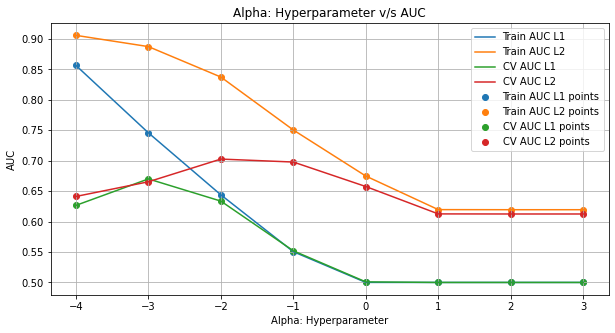

In [58]:
import matplotlib.pyplot as plt
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

svm_bow = SGDClassifier(loss='hinge',class_weight="balanced")
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}

clf = GridSearchCV(svm_bow, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)


clf.fit(X_tr_bow,Y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

bestAlpha_1=clf.best_params_['alpha']
bestPenalty_1=clf.best_params_['penalty']
bestScore_1=clf.best_score_

bestAlpha_bow=bestAlpha_1
bestPenalty_bow=bestPenalty_1
bestScore_bow=bestScore_1




print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_,"BEST REGULARIZER: ",clf.best_params_['penalty']) #clf.best_estimator_.alpha


alphas = [0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc_l1=[train_auc[i] for i in range(0,len(train_auc),2)] #range(start, stop, step)
train_auc_l2=[train_auc[i] for i in range(1,len(train_auc),2)]

cv_auc_l1=[cv_auc[i] for i in range(0,len(cv_auc),2)]
cv_auc_l2=[cv_auc[i] for i in range(1,len(cv_auc),2)]


    
plt.figure(figsize=(10,5))
plt.plot(np.log10(alphas), train_auc_l1, label='Train AUC L1')
plt.plot(np.log10(alphas), train_auc_l2, label='Train AUC L2')
plt.plot(np.log10(alphas), cv_auc_l1, label='CV AUC L1')
plt.plot(np.log10(alphas), cv_auc_l2, label='CV AUC L2')

plt.scatter(np.log10(alphas), train_auc_l1, label='Train AUC L1 points')
plt.scatter(np.log10(alphas), train_auc_l2, label='Train AUC L2 points')
plt.scatter(np.log10(alphas), cv_auc_l1, label='CV AUC L1 points')
plt.scatter(np.log10(alphas), cv_auc_l2, label='CV AUC L2 points')
plt.legend()
plt.xlabel("Alpha: Hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha: Hyperparameter v/s AUC")
plt.grid()
plt.show()





















#### Observations

1.By observing plot of auc score of train and cross validation we understand alpha=0.01 is best hyperparameter as cross validation auc is very high and does not cause overfit and underfit at alpha=0.01.


### 3.3 ROC curve with best lambda

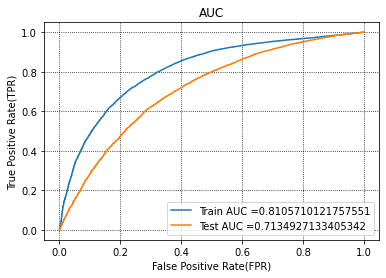

In [59]:
from sklearn.metrics import roc_curve, auc

svm_bow_testModel = SGDClassifier(loss='hinge',penalty=bestPenalty_1,alpha=bestAlpha_1,class_weight="balanced")
svm_bow_testModel.fit(X_tr_bow,Y_train)

y_train_pred=svm_bow_testModel.decision_function(X_tr_bow)
y_test_pred=svm_bow_testModel.decision_function(X_te_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

#### Observations

1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

In [60]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]

    
    #(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)    
    return predictions

In [61]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")

print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_bow=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_bow)
print("="*100)

Train confusion matrix
[[ 5473  1953]
 [10667 30948]]
Accuracy score  for Train
0.7426643012989131
Test confusion matrix
[[ 3403  2056]
 [ 9203 21390]]
Accuracy score  for Test
0.6877010984134029


In [62]:
def myplot_matrix1(data):
    plt.clf()
    plt.imshow(data, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Approved not approved matrix')
    tick_marks = np.arange(len(classNames))
    
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FN'], ['FP', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
    plt.show()

confusion matrix for train data


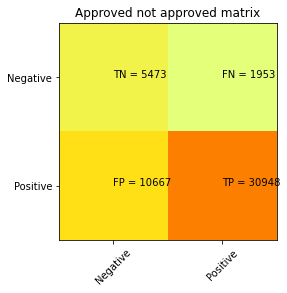

confusion matrix for Test data


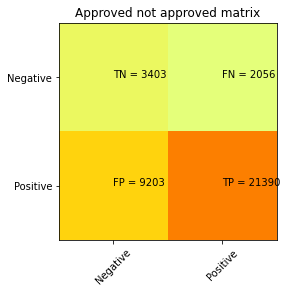

In [63]:

print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

### observations


1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 73% and test data is 69%.

3.TPR rate of test data is 91% .FPR rate of test data is 72%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 27% .FNR of test data is 8%.TNR rate of test data is more than FNR rate of test data.



 ## 4. SVM on TFIDF

### 4.1 TFIDF:Concatinating all the features

In [64]:

X_tr_tfidf=hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm)).tocsr()
X_cr_tfidf=hstack((X_cv_essay_tfidf,X_cv_title_tfidf,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm)).tocsr()
X_te_tfidf=hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)
print(X_cr_tfidf.shape, Y_cv.shape)
print(X_te_tfidf.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 7183) (49041,)
(24155, 7183) (24155,)
(36052, 7183) (36052,)


### 4.2 Hyper parameter Tuning:simple for loop for Train and cross validation

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    9.7s finished


BEST ALPHA:  0.0001  BEST SCORE:  0.6959525675812355 BEST REGULARIZER:  l1


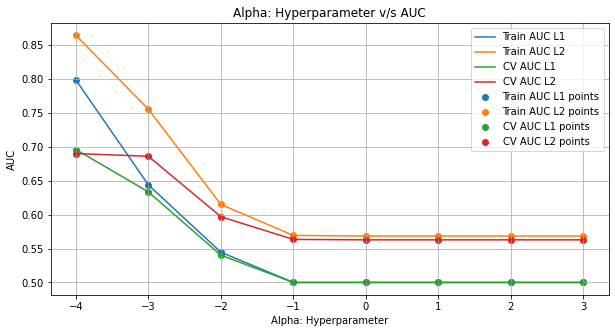

In [65]:
train_auc = []
cv_auc = []


svm_tfidf = SGDClassifier(loss='hinge',class_weight="balanced")
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}

clf = GridSearchCV(svm_tfidf, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)


clf.fit(X_tr_tfidf,Y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

bestAlpha_1=clf.best_params_['alpha']
bestPenalty_1=clf.best_params_['penalty']
bestScore_1=clf.best_score_


bestAlpha_tfidf=bestAlpha_1
bestPenalty_tfidf=bestPenalty_1
bestScore_tfidf=bestScore_1






print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_,"BEST REGULARIZER: ",clf.best_params_['penalty']) #clf.best_estimator_.alpha


alphas = [0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc_l1=[train_auc[i] for i in range(0,len(train_auc),2)] #range(start, stop, step)
train_auc_l2=[train_auc[i] for i in range(1,len(train_auc),2)]

cv_auc_l1=[cv_auc[i] for i in range(0,len(cv_auc),2)]
cv_auc_l2=[cv_auc[i] for i in range(1,len(cv_auc),2)]


    
plt.figure(figsize=(10,5))
plt.plot(np.log10(alphas), train_auc_l1, label='Train AUC L1')
plt.plot(np.log10(alphas), train_auc_l2, label='Train AUC L2')
plt.plot(np.log10(alphas), cv_auc_l1, label='CV AUC L1')
plt.plot(np.log10(alphas), cv_auc_l2, label='CV AUC L2')

plt.scatter(np.log10(alphas), train_auc_l1, label='Train AUC L1 points')
plt.scatter(np.log10(alphas), train_auc_l2, label='Train AUC L2 points')
plt.scatter(np.log10(alphas), cv_auc_l1, label='CV AUC L1 points')
plt.scatter(np.log10(alphas), cv_auc_l2, label='CV AUC L2 points')
plt.legend()
plt.xlabel("Alpha: Hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha: Hyperparameter v/s AUC")
plt.grid()
plt.show()


### Observations
1.By observing plot of auc score of train and cross validation we understand alpha=0.00001 is best hyperparameter as cross validation auc is very high and does not cause overfit and underfit at alpha=0.0001.

### 4.3 ROC curve with best lambda

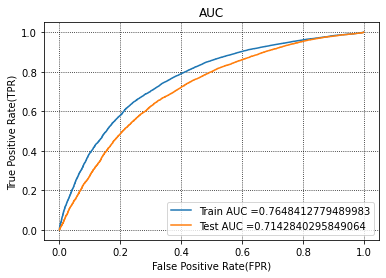

In [66]:

svm_tfidf_testModel = SGDClassifier(loss='hinge',penalty=bestPenalty_1,alpha=bestAlpha_1,class_weight="balanced")
svm_tfidf_testModel.fit(X_tr_tfidf,Y_train)

y_train_pred=svm_tfidf_testModel.decision_function(X_tr_tfidf)
y_test_pred=svm_tfidf_testModel.decision_function(X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 4.4 confusion matrix

In [67]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_avgw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_avgw2v)
print("="*100)

Train confusion matrix
[[ 5345  2081]
 [13085 28530]]
Accuracy score  for Train
0.6907485573295814
Test confusion matrix
[[ 3821  1638]
 [11445 19148]]
Accuracy score  for Test
0.637107511372462


confusion matrix for train data


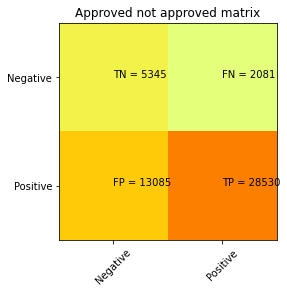

confusion matrix for Test data


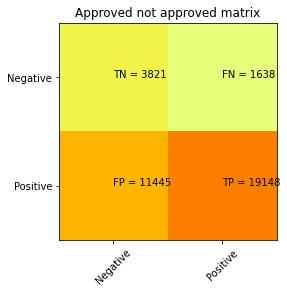

In [68]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

### observations

1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 71% and test data is 65%.

3.TPR rate of test data is91% .FPR rate of test data is 74%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 25% .FNR of test data is 8%.TNR rate of test data is more than FNR rate of test data.

## 5. SVM on AVGW2V

### 5.1 Avgw2v:Concatinating all the features

In [69]:
X_tr_avgw2v=hstack((Text_avg_w2v_train_essay,Text_avg_w2v_train_title,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm)).tocsr()
X_cr_avgw2v=hstack((Text_avg_w2v_cv_essay,Text_avg_w2v_cv_title,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm)).tocsr()
X_te_avgw2v=hstack((Text_avg_w2v_test_essay,Text_avg_w2v_test_title,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_avgw2v.shape, Y_train.shape)
print(X_cr_avgw2v.shape, Y_cv.shape)
print(X_te_avgw2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 703) (49041,)
(24155, 703) (24155,)
(36052, 703) (36052,)


### 5.2 Hyper parameter Tuning:simple for loop for Train and cross validation

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   56.9s finished


BEST ALPHA:  0.0001  BEST SCORE:  0.6897824849133843 BEST REGULARIZER:  l1


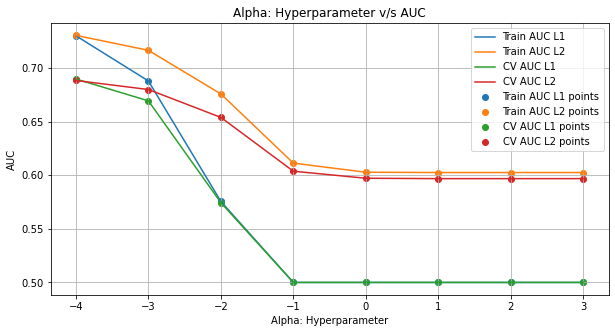

In [70]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []



svm_avgw2v = SGDClassifier(loss='hinge',class_weight="balanced")
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}

clf = GridSearchCV(svm_avgw2v, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)


clf.fit(X_tr_avgw2v,Y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

bestAlpha_1=clf.best_params_['alpha']
bestPenalty_1=clf.best_params_['penalty']
bestScore_1=clf.best_score_


bestAlpha_avgw2v=bestAlpha_1
bestPenalty_avgw2v=bestPenalty_1
bestScore_avgw2v=bestScore_1



print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_,"BEST REGULARIZER: ",clf.best_params_['penalty']) #clf.best_estimator_.alpha


alphas = [0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc_l1=[train_auc[i] for i in range(0,len(train_auc),2)] #range(start, stop, step)
train_auc_l2=[train_auc[i] for i in range(1,len(train_auc),2)]

cv_auc_l1=[cv_auc[i] for i in range(0,len(cv_auc),2)]
cv_auc_l2=[cv_auc[i] for i in range(1,len(cv_auc),2)]


    
plt.figure(figsize=(10,5))
plt.plot(np.log10(alphas), train_auc_l1, label='Train AUC L1')
plt.plot(np.log10(alphas), train_auc_l2, label='Train AUC L2')
plt.plot(np.log10(alphas), cv_auc_l1, label='CV AUC L1')
plt.plot(np.log10(alphas), cv_auc_l2, label='CV AUC L2')

plt.scatter(np.log10(alphas), train_auc_l1, label='Train AUC L1 points')
plt.scatter(np.log10(alphas), train_auc_l2, label='Train AUC L2 points')
plt.scatter(np.log10(alphas), cv_auc_l1, label='CV AUC L1 points')
plt.scatter(np.log10(alphas), cv_auc_l2, label='CV AUC L2 points')
plt.legend()
plt.xlabel("Alpha: Hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha: Hyperparameter v/s AUC")
plt.grid()
plt.show()





#### Observations

1.By observing plot of auc score of train and cross validation we understand alpha=0.0001 is best hyperparameter as cross validation auc is very high and does not cause overfit and underfit at alpha=0.0001.

### 5.3 ROC curve with best lambda

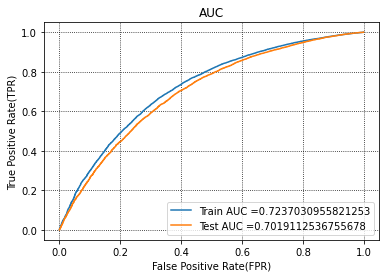

In [71]:

svm_avgw2v_testModel = SGDClassifier(loss='hinge',penalty=bestPenalty_1,alpha=bestAlpha_1,class_weight="balanced")
svm_avgw2v_testModel.fit(X_tr_avgw2v,Y_train)

y_train_pred=svm_avgw2v_testModel.decision_function(X_tr_avgw2v)
y_test_pred=svm_avgw2v_testModel.decision_function(X_te_avgw2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

#### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 5.4 confusion matrix

In [72]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_avgw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_avgw2v)
print("="*100)

Train confusion matrix
[[ 4984  2442]
 [13765 27850]]
Accuracy score  for Train
0.6695214208519402
Test confusion matrix
[[ 3841  1618]
 [12669 17924]]
Accuracy score  for Test
0.60371130589149


confusion matrix for train data


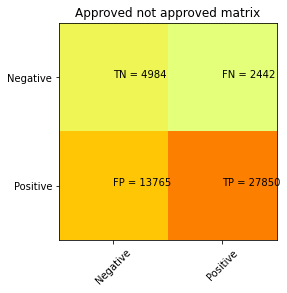

confusion matrix for Test data


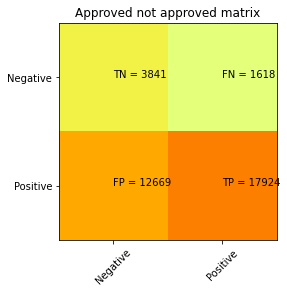

In [73]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

#### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 69% and test data is 59%.

3.TPR rate of test data is 91% .FPR rate of test data is 77%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 22% .FNR of test data is 8%.TNR rate of test data is more than FNR rate of test data.


## 6. SVM on TFIDF W2V

### 6.1 TFIDF:Concatinating all the features

In [74]:
X_tr_tfidfw2v=hstack((Text_tfidf_w2v_train_essay,Text_tfidf_w2v_train_title,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm)).tocsr()
X_cr_tfidfw2v=hstack((Text_tfidf_w2v_cv_essay,Text_tfidf_w2v_cv_title,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm)).tocsr()
X_te_tfidfw2v=hstack((Text_tfidf_w2v_test_essay,Text_tfidf_w2v_test_title,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidfw2v.shape, Y_train.shape)
print(X_cr_tfidfw2v.shape, Y_cv.shape)
print(X_te_tfidfw2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 703) (49041,)
(24155, 703) (24155,)
(36052, 703) (36052,)


### 6.2 Hyper parameter Tuning:simple for loop for Train and cross validation

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.6s finished


BEST ALPHA:  0.001  BEST SCORE:  0.6863009515526851 BEST REGULARIZER:  l2


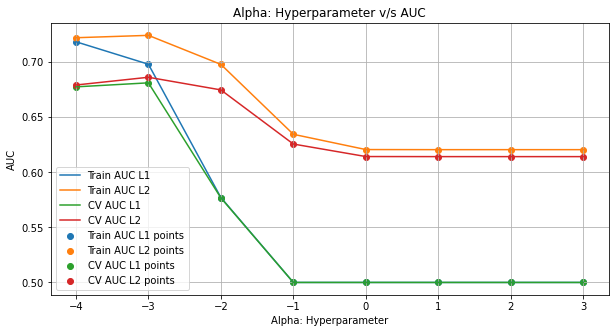

In [75]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []



svm_tfidfw2v = SGDClassifier(loss='hinge',class_weight="balanced")
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}

clf = GridSearchCV(svm_tfidfw2v, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)


clf.fit(X_tr_tfidfw2v,Y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

bestAlpha_1=clf.best_params_['alpha']
bestPenalty_1=clf.best_params_['penalty']
bestScore_1=clf.best_score_

bestAlpha_tfidfw2v=bestAlpha_1
bestPenalty_tfidfw2v=bestPenalty_1
bestScore_tfidfw2v=bestScore_1



print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_,"BEST REGULARIZER: ",clf.best_params_['penalty']) #clf.best_estimator_.alpha


alphas = [0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc_l1=[train_auc[i] for i in range(0,len(train_auc),2)] #range(start, stop, step)
train_auc_l2=[train_auc[i] for i in range(1,len(train_auc),2)]

cv_auc_l1=[cv_auc[i] for i in range(0,len(cv_auc),2)]
cv_auc_l2=[cv_auc[i] for i in range(1,len(cv_auc),2)]


    
plt.figure(figsize=(10,5))
plt.plot(np.log10(alphas), train_auc_l1, label='Train AUC L1')
plt.plot(np.log10(alphas), train_auc_l2, label='Train AUC L2')
plt.plot(np.log10(alphas), cv_auc_l1, label='CV AUC L1')
plt.plot(np.log10(alphas), cv_auc_l2, label='CV AUC L2')

plt.scatter(np.log10(alphas), train_auc_l1, label='Train AUC L1 points')
plt.scatter(np.log10(alphas), train_auc_l2, label='Train AUC L2 points')
plt.scatter(np.log10(alphas), cv_auc_l1, label='CV AUC L1 points')
plt.scatter(np.log10(alphas), cv_auc_l2, label='CV AUC L2 points')
plt.legend()
plt.xlabel("Alpha: Hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha: Hyperparameter v/s AUC")
plt.grid()
plt.show()


#### Observations

1.By observing plot of auc score of train and cross validation we understand alpha=0.001 is best hyperparameter as cross validation auc is very high and does not cause overfit and underfit at alpha=0.001.

### 6.3 ROC curve with best lambda

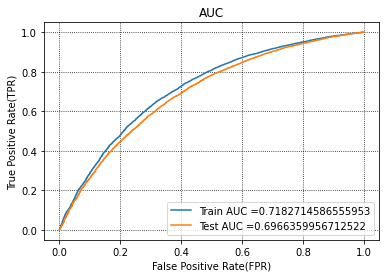

In [76]:

svm_tfidfw2v_testModel = SGDClassifier(loss='hinge',penalty=bestPenalty_1,alpha=bestAlpha_1,class_weight="balanced")
svm_tfidfw2v_testModel.fit(X_tr_tfidfw2v,Y_train)

y_train_pred=svm_tfidfw2v_testModel.decision_function(X_tr_tfidfw2v)
y_test_pred=svm_tfidfw2v_testModel.decision_function(X_te_tfidfw2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

#### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 6.4 confusion matrix

In [77]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 4941  2485]
 [13923 27692]]
Accuracy score  for Train
0.6654228094859403
Test confusion matrix
[[ 3947  1512]
 [13618 16975]]
Accuracy score  for Test
0.580328414512371


confusion matrix for train data


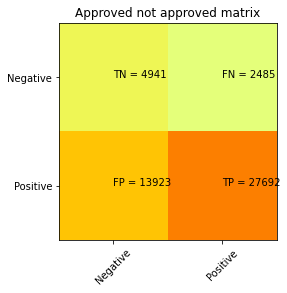

confusion matrix for Test data


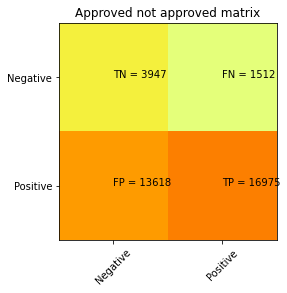

In [78]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

#### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 69% and test data is 56%.

3.TPR rate of test data is 92% .FPR rate of test data is 77%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 22% .FNR of test data is 7%.TNR rate of test data is more than FNR rate of test data.


## 7.Considering new features for analysis

### 7.1 sentmental analysis

In [79]:

X_train_essay_sentiment_neg = X_train['neg'].values.reshape(-1,1)
X_train_essay_sentiment_neu = X_train['neu'].values.reshape(-1,1)
X_train_essay_sentiment_pos = X_train['pos'].values.reshape(-1,1)
X_train_essay_sentiment_compound = X_train['compound'].values.reshape(-1,1)

X_cv_essay_sentiment_neg = X_cv['neg'].values.reshape(-1,1)
X_cv_essay_sentiment_neu = X_cv['neu'].values.reshape(-1,1)
X_cv_essay_sentiment_pos = X_cv['pos'].values.reshape(-1,1)
X_cv_essay_sentiment_compound = X_cv['compound'].values.reshape(-1,1)

X_test_essay_sentiment_neg = X_test['neg'].values.reshape(-1,1)
X_test_essay_sentiment_neu = X_test['neu'].values.reshape(-1,1)
X_test_essay_sentiment_pos = X_test['pos'].values.reshape(-1,1)
X_test_essay_sentiment_compound = X_test['compound'].values.reshape(-1,1)


print("After vectorizations")
print(X_train_essay_sentiment_neg.shape, Y_train.shape)
print(X_cv_essay_sentiment_neg.shape, Y_cv.shape)
print(X_test_essay_sentiment_neg.shape, Y_test.shape)


print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 7.2 Dimensionality reduction with TruncatedSVD

In [80]:
from sklearn.decomposition import TruncatedSVD
dimensions=[4,16,64,128,256,500,1000,1500,1600,1700,1800,1900,1999]
variance_sum=[]
for i in tqdm(dimensions):
    svd_truncated = TruncatedSVD(n_components=i, n_iter=5)
    svd_truncated.fit(X_train_essay_tfidf)
    variance_sum.append(svd_truncated.explained_variance_ratio_.sum())



100%|██████████| 13/13 [19:11<00:00, 88.55s/it] 


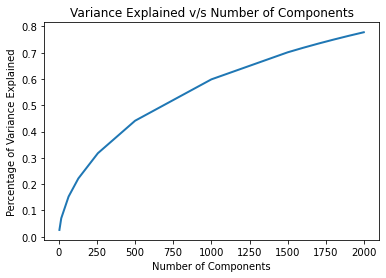

In [81]:
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
plt.title("Variance Explained v/s Number of Components")
plt.plot(dimensions,variance_sum,lw=2)
plt.show()




### 7.3 reduction of features

In [82]:
bestdim=1500
svd = TruncatedSVD(n_components=bestdim, n_iter=5)
svd.fit(X_train_essay_tfidf)
x_train_essays_tfidf_svd=svd.transform(X_train_essay_tfidf)
x_cv_essay_tfidf_svd=svd.transform(X_cv_essay_tfidf)
x_test_essays_tfidf_svd=svd.transform(X_test_essay_tfidf)

print("After dimensionality reduction")
print(x_train_essays_tfidf_svd.shape, Y_train.shape)
print(x_cv_essay_tfidf_svd.shape, Y_cv.shape)
print(x_test_essays_tfidf_svd.shape, Y_test.shape)


print("="*100)

After dimensionality reduction
(49041, 1500) (49041,)
(24155, 1500) (24155,)
(36052, 1500) (36052,)


In [83]:
from scipy.sparse import hstack
X_tr_newfeatures=hstack((x_train_essays_tfidf_svd,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm,X_train_totalwords_title_norm,X_train_totalwords_essay_norm,X_train_essay_sentiment_neg,X_train_essay_sentiment_neu,X_train_essay_sentiment_pos,X_train_essay_sentiment_compound)).tocsr()
X_te_newfeatures=hstack((x_test_essays_tfidf_svd,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm,X_test_totalwords_title_norm,X_test_totalwords_essay_norm,X_test_essay_sentiment_neg,X_test_essay_sentiment_neu,X_test_essay_sentiment_pos,X_test_essay_sentiment_compound)).tocsr()
X_cv_newfeatures=hstack((x_cv_essay_tfidf_svd,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm,X_cv_totalwords_title_norm,X_cv_totalwords_essay_norm,X_cv_essay_sentiment_neg,X_cv_essay_sentiment_neu,X_cv_essay_sentiment_pos,X_cv_essay_sentiment_compound)).tocsr()
print("Final Data matrix")
print(X_tr_newfeatures.shape, Y_train.shape)
print(X_te_newfeatures.shape, Y_cv.shape)
print(X_cv_newfeatures.shape, Y_test.shape)
print("="*100)          

Final Data matrix
(49041, 1609) (49041,)
(36052, 1609) (24155,)
(24155, 1609) (36052,)


### 7.4 Hyper parameter Tuning:simple for loop for Train and cross validation

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.9min finished


BEST ALPHA:  0.0001  BEST SCORE:  0.7052392654365356 BEST REGULARIZER:  l2


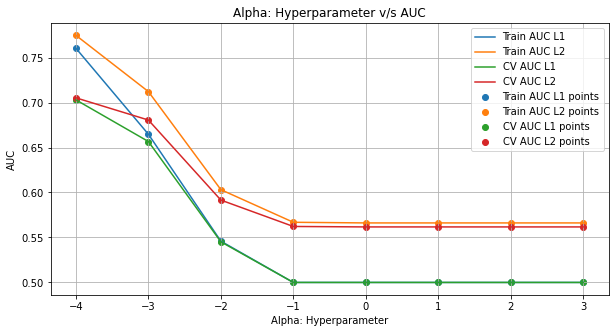

In [84]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []



svm_newFetur = SGDClassifier(loss='hinge',class_weight="balanced")
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}

clf = GridSearchCV(svm_newFetur, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)


clf.fit(X_tr_newfeatures,Y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

bestAlpha_1=clf.best_params_['alpha']
bestPenalty_1=clf.best_params_['penalty']
bestScore_1=clf.best_score_



bestAlpha_newFetur=bestAlpha_1
bestPenalty_newFetur=bestPenalty_1
bestScore_newFetur=bestScore_1







print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_,"BEST REGULARIZER: ",clf.best_params_['penalty']) #clf.best_estimator_.alpha


alphas = [0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc_l1=[train_auc[i] for i in range(0,len(train_auc),2)] #range(start, stop, step)
train_auc_l2=[train_auc[i] for i in range(1,len(train_auc),2)]

cv_auc_l1=[cv_auc[i] for i in range(0,len(cv_auc),2)]
cv_auc_l2=[cv_auc[i] for i in range(1,len(cv_auc),2)]


    
plt.figure(figsize=(10,5))
plt.plot(np.log10(alphas), train_auc_l1, label='Train AUC L1')
plt.plot(np.log10(alphas), train_auc_l2, label='Train AUC L2')
plt.plot(np.log10(alphas), cv_auc_l1, label='CV AUC L1')
plt.plot(np.log10(alphas), cv_auc_l2, label='CV AUC L2')

plt.scatter(np.log10(alphas), train_auc_l1, label='Train AUC L1 points')
plt.scatter(np.log10(alphas), train_auc_l2, label='Train AUC L2 points')
plt.scatter(np.log10(alphas), cv_auc_l1, label='CV AUC L1 points')
plt.scatter(np.log10(alphas), cv_auc_l2, label='CV AUC L2 points')
plt.legend()
plt.xlabel("Alpha: Hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha: Hyperparameter v/s AUC")
plt.grid()
plt.show()




#### Observations

1.By observing plot of auc score of train and cross validation we understand alpha=0.0001 is best hyperparameter as cross validation auc is very high and does not cause overfit and underfit at alpha=0.0001.

### 7.5 ROC curve with best lambda

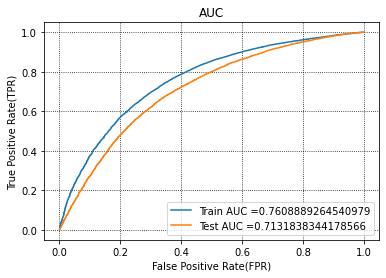

In [85]:

svm_newfetur_testModel = SGDClassifier(loss='hinge',penalty=bestPenalty_1,alpha=bestAlpha_1,class_weight="balanced")
svm_newfetur_testModel.fit(X_tr_newfeatures,Y_train)

y_train_pred=svm_newfetur_testModel.decision_function(X_tr_newfeatures)
y_test_pred=svm_newfetur_testModel.decision_function(X_te_newfeatures)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

#### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 7.6 confusion matrix

In [86]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
print(accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)


Train confusion matrix
[[ 5185  2241]
 [12558 29057]]
Accuracy score  for Train
0.6982320915152628
Test confusion matrix
[[ 3861  1598]
 [11849 18744]]
Accuracy score  for Test
0.6270109841340287


confusion matrix for train data


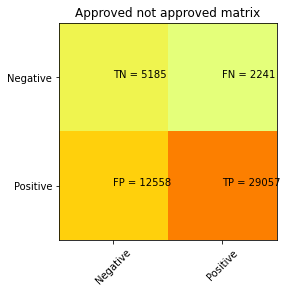

confusion matrix for Test data


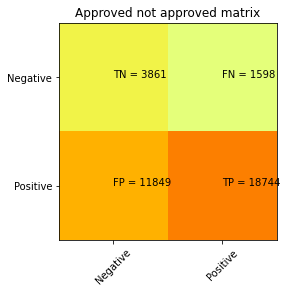

In [87]:

print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

#### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 71% and test data is 63%.

3.TPR rate of test data is 92% .FPR rate of test data is 75%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 24% .FNR of test data is 7%.TNR rate of test data is more than FNR rate of test data.

5.model is not sensible .

## 8.Model Performance Table

In [88]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyper Parameter(best alpha)", "Best penalty","bestScore"]
x.add_row([" SVM with Bow",bestAlpha_bow,bestPenalty_bow,bestScore_bow])
x.add_row([" SVM with TFIDF",bestAlpha_tfidf,bestPenalty_tfidf,bestScore_tfidf])
x.add_row([" SVM with AVGW2V",bestAlpha_avgw2v,bestPenalty_avgw2v,bestScore_avgw2v])
x.add_row([" SVM TFIDF W2V",bestAlpha_tfidfw2v,bestPenalty_tfidfw2v,bestScore_tfidfw2v])
x.add_row(["SVM with new features",bestAlpha_newFetur,bestPenalty_newFetur,bestScore_newFetur])

bestAlpha_newFetur=bestAlpha_1
bestPenalty_newFetur=bestPenalty_1
bestScore_newFetur=bestScore_1




print(x)

+-----------------------+-----------------------------+--------------+--------------------+
|       Vectorizer      | Hyper Parameter(best alpha) | Best penalty |     bestScore      |
+-----------------------+-----------------------------+--------------+--------------------+
|      SVM with Bow     |             0.01            |      l2      | 0.702684628490133  |
|     SVM with TFIDF    |            0.0001           |      l1      | 0.6959525675812355 |
|     SVM with AVGW2V   |            0.0001           |      l1      | 0.6897824849133843 |
|      SVM TFIDF W2V    |            0.001            |      l2      | 0.6863009515526851 |
| SVM with new features |            0.0001           |      l2      | 0.7052392654365356 |
+-----------------------+-----------------------------+--------------+--------------------+


### observations
1.SVM with BOW and SVM with new features give good score

2.Most model shows l2 as good regularization.